In [1]:
pip install defisheye

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.7/118.7 kB 8.3 MB/s eta 0:00:00


In [2]:
import os
import numpy as np
import random
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import keras as k
from keras import layers
from defisheye import Defisheye
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from PIL import Image, ImageDraw
import random

def generate_stars(image_size, num_stars):
    # Create a blank image
    img = Image.new('RGB', image_size, color='black')
    draw = ImageDraw.Draw(img)

    # Generate random stars on the image
    for _ in range(num_stars):
        x = random.randint(0, image_size[0] - 1)
        y = random.randint(0, image_size[1] - 1)
        brightness = random.randint(200, 255)  # Adjust brightness as needed
        radius = random.uniform(0, 2)  # Adjust size range as needed

        # Draw a filled circle for the star
        draw.ellipse([(x - radius, y - radius), (x + radius, y + radius)], fill=(brightness, brightness, brightness))

    return img

# Set the size of the image and the number of stars
image_size = (128, 128)  # Adjust as needed
num_stars = 500  # Adjust as needed

# Generate the image with stars
star_image = generate_stars(image_size, num_stars)

# Save the generated image
star_image.save('stars_image.png')

# Display the generated image
star_image.show()


In [117]:
from PIL import Image, ImageDraw
import random

def generate_circles(image_size, num_circles):
    # Create a blank image
    img = Image.new('RGB', image_size, color='black')
    draw = ImageDraw.Draw(img)

    circles = []  # Store circle information (x, y, radius) for reuse

    # Generate random circles on the image
    for _ in range(num_circles):
        x = random.randint(0, image_size[0] - 1)
        y = random.randint(0, image_size[1] - 1)
        radius = random.randint(10, 30)  # Adjust size range as needed
        brightness = 255
        circles.append((x, y, radius, brightness))

        # Draw a filled circle
        draw.ellipse([(x - radius, y - radius), (x + radius, y + radius)], fill=(brightness, brightness, brightness))

    return img, circles

def generate_colored_circle_image(image_size, circles, color):
    # Create a blank image
    img = Image.new('RGB', image_size, color='black')
    draw = ImageDraw.Draw(img)

    # Draw circles with the specified color
    for circle in circles:
        x, y, radius, brightness = circle
        if color == 'white':
          brightness = 255
        else:
          brightness = 20
        draw.ellipse([(x - radius, y - radius), (x + radius, y + radius)], fill=(brightness, brightness, brightness))

    # Save the generated image
    img.save(f'{color}_circles_image.png')

    return img

# Set the size of the image and the number of circles
image_size = (128, 128)  # Adjust as needed
num_circles = 20  # Adjust as needed

# Generate the common set of circles
original_image, circles = generate_circles(image_size, num_circles)

# Generate images with different colors
generate_colored_circle_image(image_size, circles, 'white')
gr = generate_colored_circle_image(image_size, circles, 'gray')



In [122]:
img1 = cv2.imread('stars_image.png')
img2 = cv2.imread('gray_circles_image.png')

img1[img1[:, :, 1:].all(axis=-1)] = 0
img2[img2[:, :, 1:].all(axis=-1)] = 0

dst = cv2.addWeighted(img1, 1, img2, 1, 0)
cv2.imwrite('img.png', dst)

True

In [7]:
# Generate a starry night background with clouds
def generate_starry_night_with_clouds(size, num_clouds):
    night_sky = np.zeros((size, size, 3), dtype=np.uint8)
    night_sky[:, :] = (0, 0, 0)  # Black background

    cloud_mask = generate_clouds(night_sky, num_clouds)

    # Create a mask for the stars where cloud mask is 0
    stars_mask = np.ones_like(night_sky[:, :, 0], dtype=np.uint8)
    stars_mask[cloud_mask[:, :, 0] == 0] = 0  # Set the stars region to black

    # Set the values of the stars only where the cloud mask is not present
    for i in range(3):
        night_sky[:, :, i] = np.where(stars_mask == 1, 255, night_sky[:, :, i])

    return night_sky, cloud_mask


def generate_clouds(image, num_clouds):
    # Generate black cloud-like figures
    cloud_mask = np.zeros_like(image, dtype=np.uint8)

    for _ in range(num_clouds):
        cloud_radius = random.randint(20, 50)
        cloud_center = (random.randint(0, image.shape[1]), random.randint(0, image.shape[0]))
        cv2.circle(image, cloud_center, cloud_radius, (0, 0, 0), -1)

        # Update the cloud mask
        cv2.circle(cloud_mask, cloud_center, cloud_radius, (255, 255, 255), -1)

    return cloud_mask

# Function to add salt-and-pepper noise to an image
def add_salt_and_pepper_noise(image, salt_prob, pepper_prob):
    noisy_image = image.copy()

    total_pixels = image.size

    # Add salt noise
    num_salt = int(total_pixels * salt_prob)
    salt_coords = [np.random.randint(0, i - 1, num_salt) for i in image.shape]
    noisy_image[salt_coords[0], salt_coords[1], :] = 255

    # Add pepper noise
    num_pepper = int(total_pixels * pepper_prob)
    pepper_coords = [np.random.randint(0, i - 1, num_pepper) for i in image.shape]
    noisy_image[pepper_coords[0], pepper_coords[1], :] = 0

    return noisy_image


# Function to apply fish-eye distortion
def apply_fisheye(img):

    # Set parameters
    dtype = 'linear'
    format = 'fullframe'
    fov = 180
    pfov = 120

    obj = Defisheye(img, dtype=dtype, format=format, fov=fov, pfov=pfov)
    fisheye_image = obj.convert()
    # Create a circular mask with noisy borders
    circle_mask = create_noisy_circle_mask(fisheye_image.shape[0], border_thickness=5)
    # Apply the circular mask to the noisy image
    circle_image = cv2.bitwise_and(fisheye_image, circle_mask)

    return circle_image


# Function to create a circular mask with noisy borders
def create_noisy_circle_mask(size, border_thickness):
    mask = np.zeros((size, size, 3), dtype=np.uint8)
    center = (size // 2, size // 2)
    radius = size // 2

    # Draw the circle
    cv2.circle(mask, center, radius, (255, 255, 255), -1)

    # Add noisy borders to the circle
    noisy_borders = add_salt_and_pepper_noise(np.zeros((size, size, 3), dtype=np.uint8), salt_prob=0.01, pepper_prob=0.01)
    noisy_borders = cv2.cvtColor(noisy_borders, cv2.COLOR_BGR2GRAY)
    _, noisy_borders = cv2.threshold(noisy_borders, 128, 255, cv2.THRESH_BINARY)

    # Apply the noisy borders to the circle
    mask[noisy_borders == 255] = 0

    return mask


# Generate a starry night background with clouds
night_image, cloud_mask = generate_starry_night_with_clouds(512, num_clouds=random.randint(0, 20))  # Adjust size and num_clouds as needed

# Generate 100 nights with 5 consecutive images each
for night in range(100):
    # Clone the starry night background for each night
    current_night_image = night_image.copy()
    current_cloud_mask = cloud_mask.copy()
    current_cloud_mask = cv2.cvtColor(current_cloud_mask, cv2.COLOR_BGR2HSV)

    for hour in range(5):
        # Add the cloud mask to the starry night image with transparency
        current_night_image = cv2.addWeighted(current_night_image, 1, current_cloud_mask, 1, 0)
         # Add salt-and-pepper noise
        noisy_image = add_salt_and_pepper_noise(current_night_image, salt_prob=0.01, pepper_prob=0.01)

        circle_image = apply_fisheye(noisy_image)


        # Save the generated image and mask
        # cv2.imwrite(f'night_{night + 1}_hour_{hour + 1}.png', noisy_image)
        cv2.imwrite(f'/content/gdrive/MyDrive/nights/train/masks/masks/night_{night+1}_hour_{hour+1}.png', cloud_mask)
        cv2.imwrite(f'/content/gdrive/MyDrive/nights/train/images/images/night_{night+1}_hour_{hour+1}.png', circle_image)

for night in range(30):
    # Clone the starry night background for each night
    current_night_image = night_image.copy()

    for hour in range(5):
        # Add the cloud mask to the starry night image with transparency
        current_night_image = cv2.addWeighted(current_night_image, 1, cloud_mask, 0.7, 0)
         # Add salt-and-pepper noise
        noisy_image = add_salt_and_pepper_noise(current_night_image, salt_prob=0.01, pepper_prob=0.01)

        circle_image = apply_fisheye(noisy_image)


        # Save the generated image and mask
        # cv2.imwrite(f'night_{night + 1}_hour_{hour + 1}.png', noisy_image)
        cv2.imwrite(f'/content/gdrive/MyDrive/nights/test/masks/masks/night_{101+night}_hour_{hour + 1}.png', cloud_mask)
        cv2.imwrite(f'/content/gdrive/MyDrive/nights/test/images/images/night_{101+night}_hour_{hour + 1}.png', circle_image)

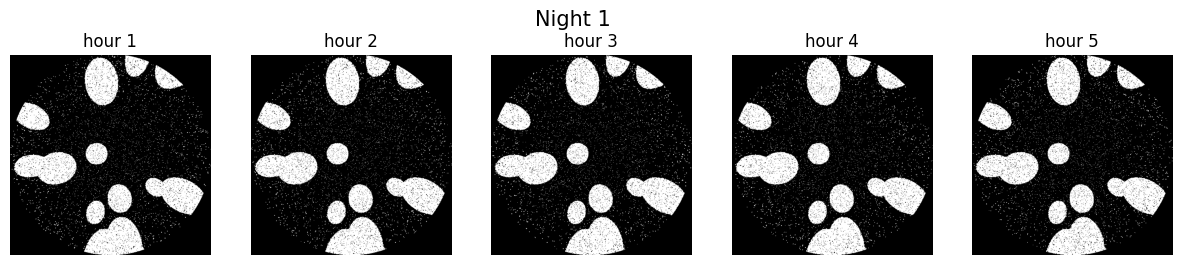

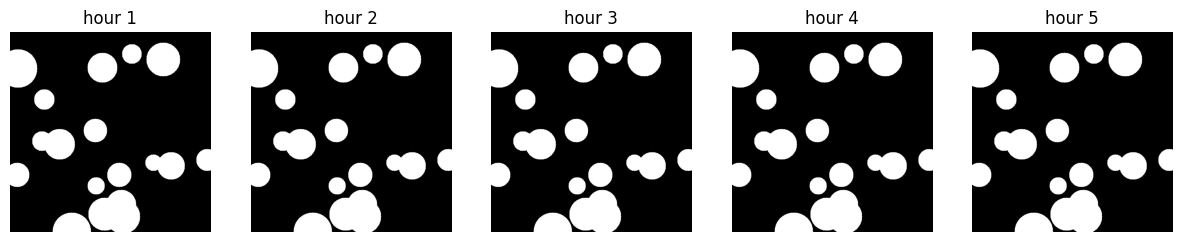

In [27]:
fig, axs = plt.subplots(1, 5, figsize=(15, 3))

night_num = 1

for i in range(5):
    img = cv2.imread(f'/content/gdrive/MyDrive/nights/train/images/images/night_{i+10}_hour_1.png')
    axs[i].imshow(img)
    axs[i].axis('off')
    axs[i].set_title(f'hour {i+1}')

plt.suptitle(f'Night {night_num}', fontsize=15)
plt.show()

fig2, axs2 = plt.subplots(1, 5, figsize=(15, 3))

for j in range(5):
    img = cv2.imread(f'/content/gdrive/MyDrive/nights/train/masks/masks/night_{j+10}_hour_1.png')
    axs2[j].imshow(img)
    axs2[j].axis('off')
    axs2[j].set_title(f'hour {j+1}')

# plt.suptitle(f'Night {night_num}', fontsize=15)
plt.show()

In [9]:
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

In [10]:
seed=24
batch_size= 32

#Define a function to perform additional preprocessing after datagen.
#For example, scale images, convert masks to categorical, etc.
def preprocess_data(img, mask, num_class):
    #Scale images
    img = img / 255. #This can be done in ImageDataGenerator but showing it outside as an example
    #Convert mask to one-hot
    labelencoder = LabelEncoder()
    n, h, w, c = mask.shape
    mask = mask.reshape(-1,1)
    mask = labelencoder.fit_transform(mask)
    mask = mask.reshape(n, h, w, c)
    # mask = to_categorical(mask, num_class)

    return (img, mask)

def trainGenerator(train_img_path, train_mask_path, num_class):

    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect')

    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)

    image_generator = image_datagen.flow_from_directory(
        directory=train_img_path,
        class_mode=None,
        color_mode='grayscale',
        target_size=(128, 128),
        batch_size=batch_size,
        seed=seed)

    mask_generator = mask_datagen.flow_from_directory(
        directory=train_mask_path,
        class_mode=None,
        color_mode='grayscale',
        target_size=(128, 128),
        batch_size=batch_size,
        seed=seed)

    train_generator = zip(image_generator, mask_generator)

    for (img, mask) in train_generator:
        img, mask = preprocess_data(img, mask, num_class)
        yield (img, mask)


In [11]:
train_img_dir = "/content/gdrive/MyDrive/nights/train/images/images/"
train_mask_dir = "/content/gdrive/MyDrive/nights/train/masks/masks/"

img_list = os.listdir(train_img_dir)
img_list.sort()  #Very important to sort as we want to match images and masks with same number.
msk_list = os.listdir(train_mask_dir)
msk_list.sort()
num_images = len(os.listdir(train_img_dir))
print("Total number of training images are: ", num_images)

Total number of training images are:  500


In [12]:
train_img_path = "/content/gdrive/MyDrive/nights/train/images/"
train_mask_path = "/content/gdrive/MyDrive/nights/train/masks/"
train_img_gen = trainGenerator(train_img_path, train_mask_path, num_class=1)

val_img_path = "/content/gdrive/MyDrive/nights/test/images/"
val_mask_path = "/content/gdrive/MyDrive/nights/test/masks/"
val_img_gen = trainGenerator(val_img_path, val_mask_path, num_class=1)

In [13]:
x, y = train_img_gen.__next__()

Found 500 images belonging to 1 classes.
Found 1000 images belonging to 1 classes.


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [14]:
x_val, y_val = val_img_gen.__next__()

Found 155 images belonging to 1 classes.
Found 305 images belonging to 1 classes.


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [15]:
"""
Utility functions for Unet3+ models
"""
def conv_block(x, kernels, kernel_size=(3, 3), strides=(1, 1), padding='same',
               is_bn=True, is_relu=True, n=2):
    """ Custom function for conv2d:
        Apply  3*3 convolutions with BN and relu.
    """
    for i in range(1, n + 1):
        x = k.layers.Conv2D(filters=kernels, kernel_size=kernel_size,
                            padding=padding, strides=strides,
                            kernel_regularizer=tf.keras.regularizers.l2(1e-4),
                            kernel_initializer=k.initializers.he_normal(seed=5))(x)
        if is_bn:
            x = k.layers.BatchNormalization()(x)
        if is_relu:
            x = k.activations.relu(x)

    return x


def dot_product(seg, cls):
    b, h, w, n = k.backend.int_shape(seg)
    seg = tf.reshape(seg, [-1, h * w, n])
    final = tf.einsum("ijk,ik->ijk", seg, cls)
    final = tf.reshape(final, [-1, h, w, n])
    return final

In [16]:
"""
UNet3+ base model
"""
def unet3plus(input_shape, output_channels):
    """ UNet3+ base model """
    filters = [64, 128, 256, 512, 1024]

    input_layer = k.layers.Input(
        shape=input_shape,
        name="input_layer"
    )  # 320*320*3

    """ Encoder"""
    # block 1
    e1 = conv_block(input_layer, filters[0])  # 320*320*64

    # block 2
    e2 = k.layers.MaxPool2D(pool_size=(2, 2))(e1)  # 160*160*64
    e2 = conv_block(e2, filters[1])  # 160*160*128

    # block 3
    e3 = k.layers.MaxPool2D(pool_size=(2, 2))(e2)  # 80*80*128
    e3 = conv_block(e3, filters[2])  # 80*80*256

    # block 4
    e4 = k.layers.MaxPool2D(pool_size=(2, 2))(e3)  # 40*40*256
    e4 = conv_block(e4, filters[3])  # 40*40*512

    # block 5
    # bottleneck layer
    e5 = k.layers.MaxPool2D(pool_size=(2, 2))(e4)  # 20*20*512
    e5 = conv_block(e5, filters[4])  # 20*20*1024

    """ Decoder """
    cat_channels = filters[0]
    cat_blocks = len(filters)
    upsample_channels = cat_blocks * cat_channels

    """ d4 """
    e1_d4 = k.layers.MaxPool2D(pool_size=(8, 8))(e1)  # 320*320*64  --> 40*40*64
    e1_d4 = conv_block(e1_d4, cat_channels, n=1)  # 320*320*64  --> 40*40*64

    e2_d4 = k.layers.MaxPool2D(pool_size=(4, 4))(e2)  # 160*160*128 --> 40*40*128
    e2_d4 = conv_block(e2_d4, cat_channels, n=1)  # 160*160*128 --> 40*40*64

    e3_d4 = k.layers.MaxPool2D(pool_size=(2, 2))(e3)  # 80*80*256  --> 40*40*256
    e3_d4 = conv_block(e3_d4, cat_channels, n=1)  # 80*80*256  --> 40*40*64

    e4_d4 = conv_block(e4, cat_channels, n=1)  # 40*40*512  --> 40*40*64

    e5_d4 = k.layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(e5)  # 80*80*256  --> 40*40*256
    e5_d4 = conv_block(e5_d4, cat_channels, n=1)  # 20*20*1024  --> 20*20*64

    d4 = k.layers.concatenate([e1_d4, e2_d4, e3_d4, e4_d4, e5_d4])
    d4 = conv_block(d4, upsample_channels, n=1)  # 40*40*320  --> 40*40*320

    """ d3 """
    e1_d3 = k.layers.MaxPool2D(pool_size=(4, 4))(e1)  # 320*320*64 --> 80*80*64
    e1_d3 = conv_block(e1_d3, cat_channels, n=1)  # 80*80*64 --> 80*80*64

    e2_d3 = k.layers.MaxPool2D(pool_size=(2, 2))(e2)  # 160*160*256 --> 80*80*256
    e2_d3 = conv_block(e2_d3, cat_channels, n=1)  # 80*80*256 --> 80*80*64

    e3_d3 = conv_block(e3, cat_channels, n=1)  # 80*80*512 --> 80*80*64

    e4_d3 = k.layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(d4)  # 40*40*320 --> 80*80*320
    e4_d3 = conv_block(e4_d3, cat_channels, n=1)  # 80*80*320 --> 80*80*64

    e5_d3 = k.layers.UpSampling2D(size=(4, 4), interpolation='bilinear')(e5)  # 20*20*320 --> 80*80*320
    e5_d3 = conv_block(e5_d3, cat_channels, n=1)  # 80*80*320 --> 80*80*64

    d3 = k.layers.concatenate([e1_d3, e2_d3, e3_d3, e4_d3, e5_d3])
    d3 = conv_block(d3, upsample_channels, n=1)  # 80*80*320 --> 80*80*320

    """ d2 """
    e1_d2 = k.layers.MaxPool2D(pool_size=(2, 2))(e1)  # 320*320*64 --> 160*160*64
    e1_d2 = conv_block(e1_d2, cat_channels, n=1)  # 160*160*64 --> 160*160*64

    e2_d2 = conv_block(e2, cat_channels, n=1)  # 160*160*256 --> 160*160*64

    d3_d2 = k.layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(d3)  # 80*80*320 --> 160*160*320
    d3_d2 = conv_block(d3_d2, cat_channels, n=1)  # 160*160*320 --> 160*160*64

    d4_d2 = k.layers.UpSampling2D(size=(4, 4), interpolation='bilinear')(d4)  # 40*40*320 --> 160*160*320
    d4_d2 = conv_block(d4_d2, cat_channels, n=1)  # 160*160*320 --> 160*160*64

    e5_d2 = k.layers.UpSampling2D(size=(8, 8), interpolation='bilinear')(e5)  # 20*20*320 --> 160*160*320
    e5_d2 = conv_block(e5_d2, cat_channels, n=1)  # 160*160*320 --> 160*160*64

    d2 = k.layers.concatenate([e1_d2, e2_d2, d3_d2, d4_d2, e5_d2])
    d2 = conv_block(d2, upsample_channels, n=1)  # 160*160*320 --> 160*160*320

    """ d1 """
    e1_d1 = conv_block(e1, cat_channels, n=1)  # 320*320*64 --> 320*320*64

    d2_d1 = k.layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(d2)  # 160*160*320 --> 320*320*320
    d2_d1 = conv_block(d2_d1, cat_channels, n=1)  # 160*160*320 --> 160*160*64

    d3_d1 = k.layers.UpSampling2D(size=(4, 4), interpolation='bilinear')(d3)  # 80*80*320 --> 320*320*320
    d3_d1 = conv_block(d3_d1, cat_channels, n=1)  # 320*320*320 --> 320*320*64

    d4_d1 = k.layers.UpSampling2D(size=(8, 8), interpolation='bilinear')(d4)  # 40*40*320 --> 320*320*320
    d4_d1 = conv_block(d4_d1, cat_channels, n=1)  # 320*320*320 --> 320*320*64

    e5_d1 = k.layers.UpSampling2D(size=(16, 16), interpolation='bilinear')(e5)  # 20*20*320 --> 320*320*320
    e5_d1 = conv_block(e5_d1, cat_channels, n=1)  # 320*320*320 --> 320*320*64

    d1 = k.layers.concatenate([e1_d1, d2_d1, d3_d1, d4_d1, e5_d1, ])
    d1 = conv_block(d1, upsample_channels, n=1)  # 320*320*320 --> 320*320*320

    # last layer does not have batchnorm and relu
    d = conv_block(d1, output_channels, n=1, is_bn=False, is_relu=False)

    output = k.activations.softmax(d)

    return tf.keras.Model(inputs=input_layer, outputs=[output], name='UNet_3Plus')

if __name__ == "__main__":
    """## Model Compilation"""
    INPUT_SHAPE = [320, 320, 1]
    OUTPUT_CHANNELS = 1

    unet_3P = unet3plus(INPUT_SHAPE, OUTPUT_CHANNELS)
    unet_3P.summary()

    # tf.keras.utils.plot_model(unet_3P, show_layer_names=True, show_shapes=True)

    # unet_3P.save("unet_3P.hdf5")

Model: "UNet_3Plus"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 320, 320, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 320, 320, 64)         640       ['input_layer[0][0]']         
                                                                                                  
 batch_normalization (Batch  (None, 320, 320, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 tf.nn.relu (TFOpLambda)     (None, 320, 320, 64)         0         ['batch_normalization

In [17]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda, Flatten
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate

In [18]:
# Building Unet by dividing encoder and decoder into blocks
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network.
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [19]:
#Define the model metrcis and load model.

num_train_imgs = len(os.listdir('/content/gdrive/MyDrive/nights/train/train/images/'))
num_val_images = len(os.listdir('/content/gdrive/MyDrive/nights/test/test/images/'))
steps_per_epoch = num_train_imgs//batch_size
val_steps_per_epoch = num_val_images//batch_size

IMG_HEIGHT = x.shape[1]
IMG_WIDTH  = x.shape[2]
IMG_CHANNELS = x.shape[3]
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
n_classes=1
print(input_shape)

(128, 128, 1)


sigmoid
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d_92 (Conv2D)          (None, 128, 128, 64)         640       ['input_4[0][0]']             
                                                                                                  
 batch_normalization_88 (Ba  (None, 128, 128, 64)         256       ['conv2d_92[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_54 (Activation)  (None, 128, 128, 64)         0         ['batch_normalizat

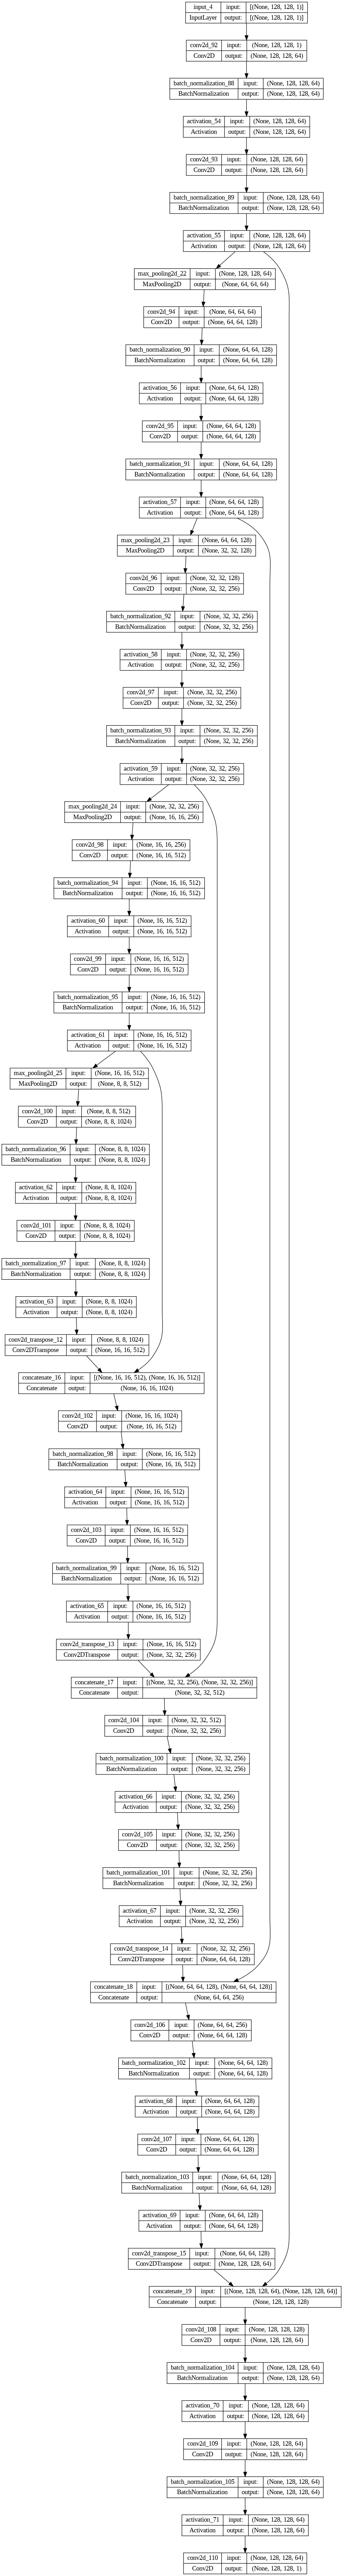

In [24]:
model = build_unet(input_shape, n_classes=1)
model.compile(optimizer=keras.optimizers.Adam(learning_rate = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
from keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [21]:
# model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)
import warnings
warnings.filterwarnings("ignore")
history=model.fit(train_img_gen,
          steps_per_epoch=3,
          epochs=50,
          verbose=1,
          validation_data=val_img_gen,
          validation_steps=3,
          batch_size=32)

Epoch 1/50
3/3 [==============================] - 340s 130s/step - loss: 0.8219 - accuracy: 0.6470 - val_loss: 0.7461 - val_accuracy: 0.2919
Epoch 2/50
3/3 [==============================] - 291s 111s/step - loss: 0.5903 - accuracy: 0.7943 - val_loss: 23.0222 - val_accuracy: 0.1614
Epoch 3/50
3/3 [==============================] - 288s 110s/step - loss: 0.4615 - accuracy: 0.8522 - val_loss: 1344.7603 - val_accuracy: 0.1571
Epoch 4/50
3/3 [==============================] - 290s 111s/step - loss: 0.4201 - accuracy: 0.8566 - val_loss: 6577.9219 - val_accuracy: 0.1624
Epoch 5/50
2/3 [===================>..........] - ETA: 1:06 - loss: 0.4036 - accuracy: 0.8533

InvalidArgumentError: ignored

# New Section

In [ ]:
#Save the model for future use
model.save('/content/gdrive/MyDrive/nights/clouds_epoch150.hdf5')

In [ ]:
###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
test_img_path = "/content/gdrive/MyDrive/nights/test/image/"
test_mask_path = "/content/gdrive/MyDrive/nights/test/mask/"
test_img_gen = trainGenerator(test_img_path, test_mask_path, num_class=1)

In [ ]:
test_image_batch, test_mask_batch = test_img_gen.__next__()

In [ ]:
y_pred=model.predict(test_image_batch)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_argmax = np.argmax(test_mask_batch, axis=3)

In [ ]:
#Predict on a few images

test_img_number = random.randint(0, len(test_image_batch)-1)
test_img = test_image_batch[test_img_number]

ground_truth=test_mask_batch[test_img_number]
ground_truth = np.argmax(ground_truth, axis=2)

print(np.unique(ground_truth))

test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)

prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

print(np.unique(predicted_img))


plt.figure(figsize=(20, 16))
plt.subplot(141)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0])
plt.subplot(142)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(143)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.subplot(144)
plt.title('Difference')
plt.imshow(ground_truth - predicted_img)
plt.colorbar()
plt.show()